# [집값 맞추기](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data_path = join('./data', 'train.csv')
test_data_path = join('./data', 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- 집값 분포가 어떤지 확인

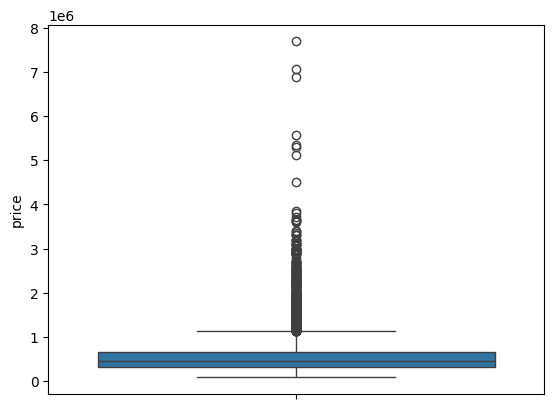

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(train['price'])
plt.show()

In [6]:
Q1 = train['price'].quantile(0.25)
Q3 = train['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 극단적으로 높은 집값 없애기
train = train[(train['price'] >= lower_bound) & (train['price'] <= upper_bound)]

In [7]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [9]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [10]:
y = np.log1p(y)

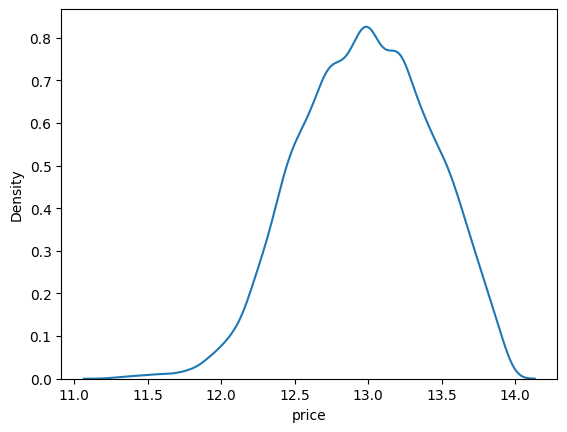

In [11]:
sns.kdeplot(y)
plt.show()

- 피쳐 추가
    - 건축 후 리노베이션까지 걸린 년수
    - 방개수 대비 욕실
    - 거주면적 대비 대지면적
    - 건축된지 몇년 되었는지
- 0으로 나눠져서 NaN이 나오는 케이스 있어서 추가 처리

In [12]:
# 1. 건축 후 리노베이션까지 걸린 년수
train['years_since_renovated'] = train['yr_renovated'] - train['yr_built']
train['years_since_renovated'] = train['years_since_renovated'].apply(lambda x: x if x > 0 else 0)
test['years_since_renovated'] = test['yr_renovated'] - test['yr_built']
test['years_since_renovated'] = test['years_since_renovated'].apply(lambda x: x if x > 0 else 0)

# 2. 방 개수 대비 욕실 개수
train['bath_per_bed'] = train['bathrooms'] / train['bedrooms']
test['bath_per_bed'] = test['bathrooms'] / test['bedrooms']

# 0으로 나누는 경우 NaN을 0으로 대체
train['bath_per_bed'] = train['bath_per_bed'].replace([np.inf, -np.inf, np.nan], 0)
test['bath_per_bed'] = test['bath_per_bed'].replace([np.inf, -np.inf, np.nan], 0)

# 3. 거주면적 대비 대지면적
train['living_per_lot'] = train['sqft_living'] / train['sqft_lot']
test['living_per_lot'] = test['sqft_living'] / test['sqft_lot']

train['living_per_lot'] = train['living_per_lot'].replace([np.inf, -np.inf, np.nan], 0)
test['living_per_lot'] = test['living_per_lot'].replace([np.inf, -np.inf, np.nan], 0)

# 4. 건축된지 몇 년 되었는지
train['age'] = 2025 - train['yr_built']
test['age'] = 2025 - test['yr_built']

In [13]:
# zip코드가 숫자지만 범주형 데이터로 보는게 맞을 것 같아서 원핫 인코딩
# test 데이터도 맞춰줌
train = pd.get_dummies(train, columns=['zipcode'])
test = pd.get_dummies(test, columns=['zipcode'])

train, test = train.align(test, join='left', axis=1, fill_value=0)
train = train.fillna(0)
test = test.fillna(0)

In [14]:
print(train.isnull().sum().sort_values(ascending=False).head(10))
print(test.isnull().sum().sort_values(ascending=False).head(10))

date           0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
waterfront     0
view           0
condition      0
grade          0
dtype: int64
date           0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
waterfront     0
view           0
condition      0
grade          0
dtype: int64


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14238 entries, 0 to 15034
Data columns (total 92 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14238 non-null  int64  
 1   bedrooms               14238 non-null  int64  
 2   bathrooms              14238 non-null  float64
 3   sqft_living            14238 non-null  int64  
 4   sqft_lot               14238 non-null  int64  
 5   floors                 14238 non-null  float64
 6   waterfront             14238 non-null  int64  
 7   view                   14238 non-null  int64  
 8   condition              14238 non-null  int64  
 9   grade                  14238 non-null  int64  
 10  sqft_above             14238 non-null  int64  
 11  sqft_basement          14238 non-null  int64  
 12  yr_built               14238 non-null  int64  
 13  yr_renovated           14238 non-null  int64  
 14  lat                    14238 non-null  float64
 15  long   

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [17]:
def robust_scale(df):
    robustscaler = RobustScaler()
    robustscaler.fit(df)

    df = robustscaler.transform(df) 
    return df

In [18]:
df = pd.concat((train, test), axis=0)

print('train shape:', train.shape)
print('test shape:', test.shape)
print('df shape:', df.shape)

train shape: (14238, 92)
test shape: (6468, 92)
df shape: (20706, 92)


In [19]:
# robust cale로 스케일링
robust_scale(df)

array([[ 0.        ,  0.        , -1.25      , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.96842105, -1.        , -1.25      , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.96842105,  0.        , -0.25      , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.96842105,  0.        ,  0.25      , ...,  0.        ,
         0.        ,  0.        ],
       [-0.04210526, -1.        , -1.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.95789474,  0.        ,  0.25      , ...,  0.        ,
         0.        ,  0.        ]], shape=(20706, 92))

In [20]:
# random_state 2025로 고정
random_state=2025

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [ ]:
from sklearn.ensemble import StackingRegressor

# 시도해볼 방법에 나온 스태킹 사용해보기
def get_stacking_model():
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    gboost = GradientBoostingRegressor(random_state=random_state)
    xgboost = XGBRegressor(random_state=random_state)
    lightgbm = LGBMRegressor(random_state=random_state)
    rdforest = RandomForestRegressor(random_state=random_state)

    stack_models = [
        ('gb', gboost),
        ('xgb', xgboost),
        ('lgbm', lightgbm),
        ('rf', rdforest)
    ]
    
    stack_reg = StackingRegressor(stack_models, final_estimator=gboost)
    stack_reg.fit(X_train, y_train)
    
    y_pred = stack_reg.predict(X_test)
    print(f'rmse: {rmse(y_pred, y_test)}')
    
    return stack_reg

model = get_stacking_model()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 11390, number of used features: 91
[LightGBM] [Info] Start training from score 12.975149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2815
[LightGBM] [Info] Number of data points in the train set: 9112, number of used features: 91
[LightGBM] [Info] Start training from score 12.974668
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2821
[LightGBM] [Info] Number of data points in the train set: 9112, number of used features: 91
[LightGBM] [Info] Start tra

In [22]:
"""
1. `test`에 대해 예측합니다.
2. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성
def save_submission(model, test, model_name, rmsle=None):
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = './data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(model, test, 'StackingRegressor', '73381.80924467753')

./data/submission_StackingRegressor_RMSE_73381.80924467753.csv saved!


### 오늘의 회고

- 어제랑 다르게 난이도가 너무나 오른 것 아닌가
- 감도 못잡겠다.
- 왜 baseline이 더 높은 점수가 나오는 것인가
- lgbm regressor 값을 바꿔도 유의미한 결과는 없어서 어려웠고 전처리로 다시 돌아가봄
- 가격중에 아웃라이어를 없앴더니 점수가 확 올랐는데 이게 잘한건지는 사실 모르겠음
- 피처들도 여러개 생성해봄, 할 수 있는 건 해봤는데 오늘건 좀 파악하기가 어려웠다.